<a href="https://colab.research.google.com/github/yanarkpanjaitan/sentimentanalysis/blob/main/InterestRate_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import all libraries

In [ ]:
! pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import *
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Function

In [ ]:
def evalModel(x, y, clf):
    print('Accuracy  : %.5f' % accuracy_score(y, clf.predict(x)))
    print('Recall    : %.5f' % recall_score(y, clf.predict(x), average='micro'))
    print('Precision : %.5f' % precision_score(y, clf.predict(x), average='micro'))
    print('F1 score  : %.5f' % f1_score(y, clf.predict(x), average='micro'))

# Data Exploratory

### Read Dataset Train

In [ ]:
train = pd.read_csv("Train.csv", thousands=',')
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,7000,< 1 year,Rent,68000.00,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,30000,4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.00,12,24,Female,3
2,10000003,24725,7 years,Mortgage,75566.40,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,16000,< 1 year,NaN,56160.00,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,17000,8 years,Own,96000.00,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


## EDA

In [ ]:
train.shape

(164309, 14)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  int64  
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.describe()

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate
count,164309.00,164309.00,139207.00,164309.00,164309.00,75930.00,164309.00,164309.00,164309.00
mean,10082155.00,14349.34,73331.16,17.21,0.78,34.23,11.19,25.07,2.16
std,47432.07,8281.87,60377.50,7.85,1.03,21.76,4.99,11.58,0.74
min,10000001.00,500.00,4000.00,0.00,0.00,0.00,0.00,2.00,1.00
25%,10041078.00,8000.00,45000.00,11.37,0.00,16.00,8.00,17.00,2.00
50%,10082155.00,12075.00,63000.00,16.84,0.00,31.00,10.00,23.00,2.00
75%,10123232.00,20000.00,88697.50,22.78,1.00,50.00,14.00,32.00,3.00
max,10164309.00,35000.00,7500000.00,39.99,8.00,180.00,76.00,156.00,3.00


In [ ]:
count_y = train['Interest_Rate'].value_counts()
count_y

2    70580
3    59923
1    33806
Name: Interest_Rate, dtype: int64

In [ ]:
percent_y = train['Interest_Rate'].value_counts() * 100/len(train['Interest_Rate'])
percent_y

2   42.96
3   36.47
1   20.57
Name: Interest_Rate, dtype: float64

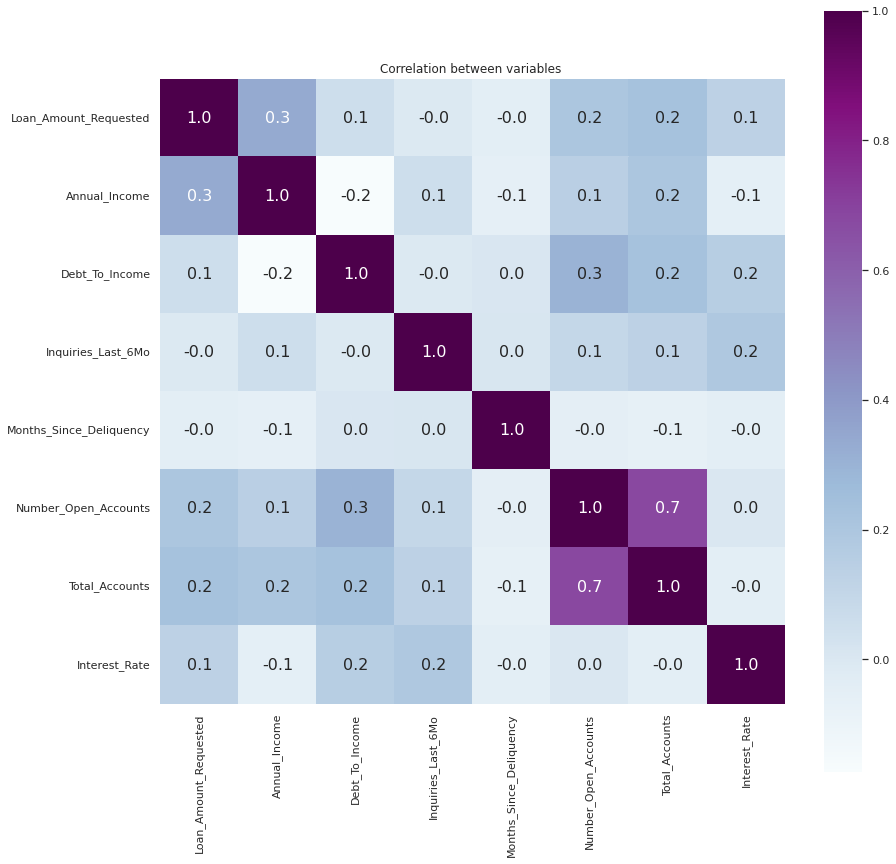

In [ ]:
correlation = train.drop(columns = ['Loan_ID']).corr()
f, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(correlation, vmax=1, square=True, cmap="BuPu",annot=True, fmt='.1f',ax=ax);
plt.title("Correlation between variables ")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

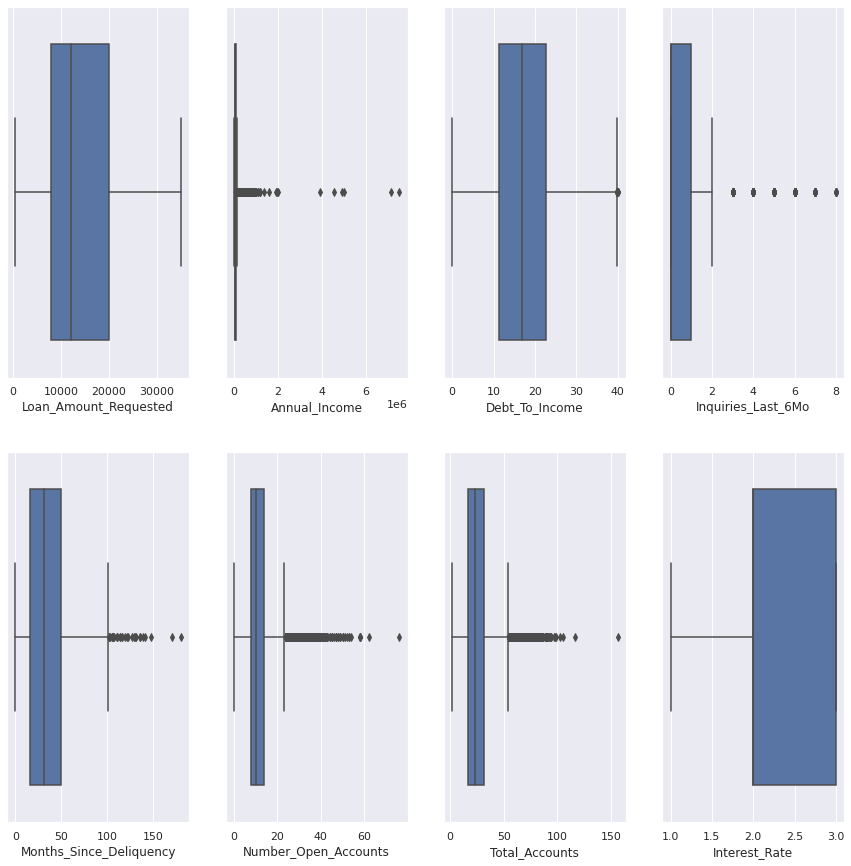

In [ ]:
#set seaborn plotting
sns.set()
fig, axes = plt.subplots(2,4,figsize=(15, 15))
sns.boxplot(train['Loan_Amount_Requested'],ax=axes[0,0])
sns.boxplot(train['Annual_Income'],ax=axes[0,1])
sns.boxplot(train['Debt_To_Income'],ax=axes[0,2])
sns.boxplot(train['Inquiries_Last_6Mo'],ax=axes[0,3])
sns.boxplot(train['Months_Since_Deliquency'],ax=axes[1,0])
sns.boxplot(train['Number_Open_Accounts'],ax=axes[1,1])
sns.boxplot(train['Total_Accounts'],ax=axes[1,2])
sns.boxplot(train['Interest_Rate'],ax=axes[1,3])

# Preparation

##Training

### Check Missing Value

In [ ]:
count_missing = train.isnull().sum()
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'column_name': train.columns,
                                 'count_missing': count_missing,
                                 'percent_missing': percent_missing})
missing_value_df = missing_value_df.reset_index().iloc[:, 1:4]
missing_value_df

,column_name,count_missing,percent_missing
0,Loan_ID,0,0.00
1,Loan_Amount_Requested,0,0.00
2,Length_Employed,7371,4.49
3,Home_Owner,25349,15.43
4,Annual_Income,25102,15.28
5,Income_Verified,0,0.00
6,Purpose_Of_Loan,0,0.00
7,Debt_To_Income,0,0.00
8,Inquiries_Last_6Mo,0,0.00
9,Months_Since_Deliquency,88379,53.79


In [ ]:
filter_missing_value = missing_value_df[missing_value_df['percent_missing'] > 30]

filter_exclude_column = list(filter_missing_value['column_name'].values)
filter_exclude_column

['Months_Since_Deliquency']

In [ ]:
train_dropmissing = train.drop(columns = ['Months_Since_Deliquency'])

In [ ]:
train_dropmissing.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,7000,< 1 year,Rent,68000.00,not verified,car,18.37,0,9,14,Female,1
1,10000002,30000,4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,12,24,Female,3
2,10000003,24725,7 years,Mortgage,75566.40,VERIFIED - income source,debt_consolidation,15.88,0,12,16,Male,3
3,10000004,16000,< 1 year,NaN,56160.00,VERIFIED - income source,debt_consolidation,14.34,3,16,22,Male,3
4,10000005,17000,8 years,Own,96000.00,VERIFIED - income source,debt_consolidation,22.17,1,19,30,Female,1


In [ ]:
train_dropmissing['Length_Employed']=train_dropmissing['Length_Employed'].fillna((train_dropmissing['Length_Employed'].mode()[0]))
train_dropmissing['Home_Owner']=train_dropmissing['Home_Owner'].fillna((train_dropmissing['Home_Owner'].mode()[0]))
train_dropmissing['Annual_Income']=train_dropmissing['Annual_Income'].fillna((train_dropmissing['Annual_Income'].mean()))

In [ ]:
train_dropmissing.isnull().sum()

Loan_ID                  0
Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Total_Accounts           0
Gender                   0
Interest_Rate            0
dtype: int64

### Chi-Square Test for Independence

In [ ]:
cat_var = ['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan', 'Gender']
num_var = ['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts']

In [ ]:
chi2_check = {}
for col in cat_var:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(train_dropmissing['Interest_Rate'], train_dropmissing[col]))
    chi2_check.setdefault('feature',[]).append(col)
    chi2_check.setdefault('p-value',[]).append(round(p, 5))
# Calculate chi-statistic with the target variable
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,feature,p-value
0,Length_Employed,0.00
1,Home_Owner,0.00
2,Income_Verified,0.00
3,Purpose_Of_Loan,0.00
4,Gender,0.16


In [ ]:
drop_cat_vars = chi2_result[chi2_result['p-value'] > 0.05]['feature'].to_list()
drop_cat_vars

['Gender']

In [ ]:
used_vars = [x for x in train_dropmissing.columns if x not in drop_cat_vars]

train_dropmissing_v2 = train_dropmissing[used_vars]

print(train_dropmissing.shape)
train_dropmissing_v2.head()

(164309, 13)


,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Interest_Rate
0,10000001,7000,< 1 year,Rent,68000.00,not verified,car,18.37,0,9,14,1
1,10000002,30000,4 years,Mortgage,73331.16,VERIFIED - income,debt_consolidation,14.93,0,12,24,3
2,10000003,24725,7 years,Mortgage,75566.40,VERIFIED - income source,debt_consolidation,15.88,0,12,16,3
3,10000004,16000,< 1 year,Mortgage,56160.00,VERIFIED - income source,debt_consolidation,14.34,3,16,22,3
4,10000005,17000,8 years,Own,96000.00,VERIFIED - income source,debt_consolidation,22.17,1,19,30,1


### Check Outliers

In [ ]:
result_cek = []
for col in num_var:
    min_value = train_dropmissing_v2[col].min()
    max_value = train_dropmissing_v2[col].max()

    Q1 = np.percentile(train_dropmissing_v2[col], 25, interpolation = 'midpoint')
    Q3 = np.percentile(train_dropmissing_v2[col], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    limit_low = Q1 - 1.5*IQR
    limit_up = Q3 + 1.5*IQR

    if min_value < limit_low or max_value > limit_up:
        result_cek.append('Have outliers')
    else:
        result_cek.append('Has no outliers')

df_cek_outlier = pd.DataFrame({
    'Variable' : num_var,
    'Outlier Check' : result_cek
}).sort_values(by='Outlier Check')

df_cek_outlier

,Variable,Outlier Check
0,Loan_Amount_Requested,Has no outliers
1,Annual_Income,Have outliers
2,Debt_To_Income,Have outliers
3,Inquiries_Last_6Mo,Have outliers
4,Number_Open_Accounts,Have outliers
5,Total_Accounts,Have outliers


In [ ]:
outlier_vars = df_cek_outlier[df_cek_outlier['Outlier Check'] == 'Have outliers']['Variable'].to_list()
outlier_vars

['Annual_Income',
 'Debt_To_Income',
 'Inquiries_Last_6Mo',
 'Number_Open_Accounts',
 'Total_Accounts']

In [ ]:
def find_outlier(data=None, feature=None, mode='z-score'):
    "Parameters"
    "----------"
    "data : <pandas DataFrame>"
    "mode : <option> (z-score, std, iqr)"

    if mode == 'z-score':
        data['z_score'] = (data[feature] - data[feature].mean()) / data[feature].std()
        return data['z_score']
    elif mode == 'std':
        upper_limit = data[feature].mean() + 3 * data[feature].std()
        lower_limit = data[feature].mean() - 3 * data[feature].std()
        outlier = {'upper':upper_limit, 'lower':lower_limit}
        return outlier
    elif mode == 'iqr':
        q1= data[feature].quantile(0.25)
        q3 = data[feature].quantile(0.75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
        outlier = {'upper':upper_limit, 'lower':lower_limit}
        return outlier
    else:
        print('[WARNING] please select mode (z-score, std or iqr) !!!')
        return None

In [ ]:
for col in outlier_vars:
    outlier = find_outlier(train_dropmissing_v2, col, 'iqr')
    lower = outlier['lower']
    upper = outlier['upper']
    train_dropmissing_v2[col] = np.where(train_dropmissing_v2[col] < lower, lower, train_dropmissing_v2[col])
    train_dropmissing_v2[col] = np.where(train_dropmissing_v2[col] > upper, upper, train_dropmissing_v2[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
result_cek = []
for col in num_var:
    min_value = train_dropmissing_v2[col].min()
    max_value = train_dropmissing_v2[col].max()

    Q1 = np.percentile(train_dropmissing_v2[col], 25, interpolation = 'midpoint')
    Q3 = np.percentile(train_dropmissing_v2[col], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    limit_low = Q1 - 1.5*IQR
    limit_up = Q3 + 1.5*IQR

    if min_value < limit_low or max_value > limit_up:
        result_cek.append('Have outliers')
    else:
        result_cek.append('Has no outliers')

df_cek_outlier = pd.DataFrame({
    'Variable' : num_var,
    'Outlier Check' : result_cek
}).sort_values(by='Outlier Check')

df_cek_outlier

,Variable,Outlier Check
0,Loan_Amount_Requested,Has no outliers
1,Annual_Income,Has no outliers
2,Debt_To_Income,Has no outliers
3,Inquiries_Last_6Mo,Has no outliers
4,Number_Open_Accounts,Has no outliers
5,Total_Accounts,Has no outliers


In [ ]:
data_bersih = train_dropmissing_v2.copy()
data_bersih.shape

(164309, 12)

In [ ]:
data_bersih.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Loan_ID                164309 non-null  int64  
 1   Loan_Amount_Requested  164309 non-null  int64  
 2   Length_Employed        164309 non-null  object 
 3   Home_Owner             164309 non-null  object 
 4   Annual_Income          164309 non-null  float64
 5   Income_Verified        164309 non-null  object 
 6   Purpose_Of_Loan        164309 non-null  object 
 7   Debt_To_Income         164309 non-null  float64
 8   Inquiries_Last_6Mo     164309 non-null  float64
 9   Number_Open_Accounts   164309 non-null  float64
 10  Total_Accounts         164309 non-null  float64
 11  Interest_Rate          164309 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 15.0+ MB


In [ ]:
data_bersih.to_csv('data_bersih.csv')

### Standardize the categorical value

In [ ]:
data_bersih['Length_Employed'].unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', '6 years', '9 years', '3 years', '5 years'],
      dtype=object)

In [ ]:
data_bersih['Length_Employed'] = data_bersih['Length_Employed'].replace({'< 1 year': 'lessthan_1year', '1 year' : '1year', '2 years' : '2years', '3 years' : '3years', '4 years' : '4years', '5 years' : '5years', '6 years' : '6years', '7 years' : '7years', '8 years' : '8years', '9 years' : '9years', '10+ years' : 'greatthan_10years'})
data_bersih['Length_Employed'].unique()

array(['lessthan_1year', '4years', '7years', '8years', '2years',
       'greatthan_10years', '1year', '6years', '9years', '3years',
       '5years'], dtype=object)

In [ ]:
data_bersih['Home_Owner'].unique()

array(['Rent', 'Mortgage', 'Own', 'Other', 'None'], dtype=object)

In [ ]:
data_bersih['Income_Verified'].unique()

array(['not verified', 'VERIFIED - income', 'VERIFIED - income source'],
      dtype=object)

In [ ]:
data_bersih['Income_Verified'] = data_bersih['Income_Verified'].replace({'not verified' : 'not_verified', 'VERIFIED - income' : 'VERIFIED_income','VERIFIED - income source' : 'VERIFIED_income_source'} )
data_bersih['Income_Verified'].unique()

array(['not_verified', 'VERIFIED_income', 'VERIFIED_income_source'],
      dtype=object)

In [ ]:
data_bersih['Purpose_Of_Loan'].unique()

array(['car', 'debt_consolidation', 'credit_card', 'home_improvement',
       'major_purchase', 'other', 'medical', 'small_business', 'moving',
       'wedding', 'vacation', 'house', 'educational', 'renewable_energy'],
      dtype=object)

### One Hot Encoding for categorical features

In [ ]:
cat_var_v2 = ['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan']
num_var_v2 = ['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts']

In [ ]:
data_bersih_OH = pd.get_dummies(data_bersih, columns = cat_var_v2)

print(data_bersih_OH.shape)
data_bersih_OH.head()

(164309, 41)


,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Interest_Rate,Length_Employed_1year,Length_Employed_2years,...,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding
0,10000001,7000,68000.00,18.37,0.00,9.00,14.00,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10000002,30000,73331.16,14.93,0.00,12.00,24.00,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10000003,24725,75566.40,15.88,0.00,12.00,16.00,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10000004,16000,56160.00,14.34,2.50,16.00,22.00,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10000005,17000,96000.00,22.17,1.00,19.00,30.00,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Standar Scaler for numerical features

In [ ]:
data_bersih_SS = data_bersih_OH.copy()

scaler = StandardScaler().fit(data_bersih_SS[num_var_v2].values)
train_features = scaler.transform(data_bersih_SS[num_var_v2].values)

data_bersih_SS[num_var_v2] = train_features
print(data_bersih_SS.shape)
data_bersih_SS.head()

(164309, 41)


,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Interest_Rate,Length_Employed_1year,Length_Employed_2years,...,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding
0,10000001,-0.89,-0.06,0.15,-0.84,-0.45,-0.98,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10000002,1.89,0.13,-0.29,-0.84,0.19,-0.08,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10000003,1.25,0.21,-0.17,-0.84,0.19,-0.80,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10000004,0.20,-0.47,-0.37,2.09,1.05,-0.26,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10000005,0.32,0.93,0.63,0.33,1.70,0.45,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Testing

### Read Dataset

In [ ]:
test = pd.read_csv("Test.csv", thousands=',')
test.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,27500,10+ years,Mortgage,129000.00,VERIFIED - income,debt_consolidation,12.87,0,68.00,10,37,Male
1,10164311,26000,10+ years,NaN,110000.00,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,6075,< 1 year,Rent,75000.00,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
3,10164313,12000,10+ years,Mortgage,73000.00,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
4,10164314,35000,< 1 year,Mortgage,156000.00,not verified,debt_consolidation,9.62,0,26.00,9,21,Male


In [ ]:
test.shape

(109541, 13)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109541 entries, 0 to 109540
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  109541 non-null  int64  
 1   Loan_Amount_Requested    109541 non-null  int64  
 2   Length_Employed          104605 non-null  object 
 3   Home_Owner               92830 non-null   object 
 4   Annual_Income            92643 non-null   float64
 5   Income_Verified          109541 non-null  object 
 6   Purpose_Of_Loan          109541 non-null  object 
 7   Debt_To_Income           109541 non-null  float64
 8   Inquiries_Last_6Mo       109541 non-null  int64  
 9   Months_Since_Deliquency  50682 non-null   float64
 10  Number_Open_Accounts     109541 non-null  int64  
 11  Total_Accounts           109541 non-null  int64  
 12  Gender                   109541 non-null  object 
dtypes: float64(3), int64(5), object(5)
memory usage: 10.9+ MB


In [ ]:
test = test.drop(columns = ['Gender', 'Months_Since_Deliquency'])

### Check Missing Value

In [ ]:
count_missing_test = test.isnull().sum()
percent_missing_test = test.isnull().sum() * 100 / len(test)
missing_value_df_test = pd.DataFrame({'column_name': test.columns,
                                 'count_missing': count_missing_test,
                                 'percent_missing': percent_missing_test})
missing_value_df_test = missing_value_df_test.reset_index().iloc[:, 1:4]
missing_value_df_test

,column_name,count_missing,percent_missing
0,Loan_ID,0,0.00
1,Loan_Amount_Requested,0,0.00
2,Length_Employed,4936,4.51
3,Home_Owner,16711,15.26
4,Annual_Income,16898,15.43
5,Income_Verified,0,0.00
6,Purpose_Of_Loan,0,0.00
7,Debt_To_Income,0,0.00
8,Inquiries_Last_6Mo,0,0.00
9,Number_Open_Accounts,0,0.00


In [ ]:
test['Length_Employed']=test['Length_Employed'].fillna((train_dropmissing['Length_Employed'].mode()[0]))
test['Home_Owner']=test['Home_Owner'].fillna((train_dropmissing['Home_Owner'].mode()[0]))
test['Annual_Income']=test['Annual_Income'].fillna((train_dropmissing['Annual_Income'].mean()))

In [ ]:
test.isnull().sum()

Loan_ID                  0
Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Total_Accounts           0
dtype: int64

### Check Outliers

In [ ]:
cat_var_test = ['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan', 'Gender']
num_var_test = ['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts']

In [ ]:
result_cek = []
for col in num_var_test:
    min_value = test[col].min()
    max_value = test[col].max()

    Q1 = np.percentile(test[col], 25, interpolation = 'midpoint')
    Q3 = np.percentile(test[col], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    limit_low = Q1 - 1.5*IQR
    limit_up = Q3 + 1.5*IQR

    if min_value < limit_low or max_value > limit_up:
        result_cek.append('Have outliers')
    else:
        result_cek.append('Has no outliers')

df_cek_outlier_test = pd.DataFrame({
    'Variable' : num_var_test,
    'Outlier Check' : result_cek
}).sort_values(by='Outlier Check')

df_cek_outlier_test

,Variable,Outlier Check
0,Loan_Amount_Requested,Has no outliers
1,Annual_Income,Have outliers
2,Debt_To_Income,Have outliers
3,Inquiries_Last_6Mo,Have outliers
4,Number_Open_Accounts,Have outliers
5,Total_Accounts,Have outliers


In [ ]:
outlier_vars_test = df_cek_outlier_test[df_cek_outlier_test['Outlier Check'] == 'Have outliers']['Variable'].to_list()
outlier_vars_test

['Annual_Income',
 'Debt_To_Income',
 'Inquiries_Last_6Mo',
 'Number_Open_Accounts',
 'Total_Accounts']

In [ ]:
def find_outlier(data=None, feature=None, mode='z-score'):
    "Parameters"
    "----------"
    "data : <pandas DataFrame>"
    "mode : <option> (z-score, std, iqr)"

    if mode == 'z-score':
        data['z_score'] = (data[feature] - data[feature].mean()) / data[feature].std()
        return data['z_score']
    elif mode == 'std':
        upper_limit = data[feature].mean() + 3 * data[feature].std()
        lower_limit = data[feature].mean() - 3 * data[feature].std()
        outlier = {'upper':upper_limit, 'lower':lower_limit}
        return outlier
    elif mode == 'iqr':
        q1= data[feature].quantile(0.25)
        q3 = data[feature].quantile(0.75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
        outlier = {'upper':upper_limit, 'lower':lower_limit}
        return outlier
    else:
        print('[WARNING] please select mode (z-score, std or iqr) !!!')
        return None

In [ ]:
for col in outlier_vars:
    outlier = find_outlier(test, col, 'iqr')
    lower = outlier['lower']
    upper = outlier['upper']
    test[col] = np.where(test[col] < lower, lower, test[col])
    test[col] = np.where(test[col] > upper, upper, test[col])

In [ ]:
result_cek = []
for col in num_var_test:
    min_value = test[col].min()
    max_value = test[col].max()

    Q1 = np.percentile(test[col], 25, interpolation = 'midpoint')
    Q3 = np.percentile(test[col], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    limit_low = Q1 - 1.5*IQR
    limit_up = Q3 + 1.5*IQR

    if min_value < limit_low or max_value > limit_up:
        result_cek.append('Have outliers')
    else:
        result_cek.append('Has no outliers')

df_cek_outlier_test = pd.DataFrame({
    'Variable' : num_var_test,
    'Outlier Check' : result_cek
}).sort_values(by='Outlier Check')

df_cek_outlier_test

,Variable,Outlier Check
0,Loan_Amount_Requested,Has no outliers
1,Annual_Income,Has no outliers
2,Debt_To_Income,Has no outliers
3,Inquiries_Last_6Mo,Has no outliers
4,Number_Open_Accounts,Has no outliers
5,Total_Accounts,Has no outliers


In [ ]:
data_bersih_test = test.copy()
data_bersih_test.shape

(109541, 11)

In [ ]:
data_bersih_test.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts'],
      dtype='object')

### Standardize the categorical value

In [ ]:
data_bersih_test['Length_Employed'].unique()

array(['10+ years', '< 1 year', '6 years', '8 years', '1 year', '3 years',
       '2 years', '4 years', '7 years', '5 years', '9 years'],
      dtype=object)

In [ ]:
data_bersih_test['Length_Employed'] = data_bersih_test['Length_Employed'].replace({'< 1 year': 'lessthan_1year', '1 year' : '1year', '2 years' : '2years', '3 years' : '3years', '4 years' : '4years', '5 years' : '5years', '6 years' : '6years', '7 years' : '7years', '8 years' : '8years', '9 years' : '9years', '10+ years' : 'greatthan_10years'})
data_bersih_test['Length_Employed'].unique()

array(['greatthan_10years', 'lessthan_1year', '6years', '8years', '1year',
       '3years', '2years', '4years', '7years', '5years', '9years'],
      dtype=object)

In [ ]:
data_bersih_test['Home_Owner'].unique()

array(['Mortgage', 'Rent', 'Own', 'Other', 'None'], dtype=object)

In [ ]:
data_bersih_test['Income_Verified'].unique()

array(['VERIFIED - income', 'not verified', 'VERIFIED - income source'],
      dtype=object)

In [ ]:
data_bersih_test['Income_Verified'] = data_bersih_test['Income_Verified'].replace({'not verified' : 'not_verified', 'VERIFIED - income' : 'VERIFIED_income','VERIFIED - income source' : 'VERIFIED_income_source'} )
data_bersih_test['Income_Verified'].unique()

array(['VERIFIED_income', 'not_verified', 'VERIFIED_income_source'],
      dtype=object)

In [ ]:
data_bersih_test['Purpose_Of_Loan'].unique()

array(['debt_consolidation', 'credit_card', 'home_improvement', 'other',
       'small_business', 'vacation', 'wedding', 'major_purchase', 'car',
       'house', 'medical', 'renewable_energy', 'moving', 'educational'],
      dtype=object)

### One Hot Encoding for categorical features

In [ ]:
data_bersih_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109541 entries, 0 to 109540
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Loan_ID                109541 non-null  int64  
 1   Loan_Amount_Requested  109541 non-null  int64  
 2   Length_Employed        109541 non-null  object 
 3   Home_Owner             109541 non-null  object 
 4   Annual_Income          109541 non-null  float64
 5   Income_Verified        109541 non-null  object 
 6   Purpose_Of_Loan        109541 non-null  object 
 7   Debt_To_Income         109541 non-null  float64
 8   Inquiries_Last_6Mo     109541 non-null  float64
 9   Number_Open_Accounts   109541 non-null  float64
 10  Total_Accounts         109541 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 9.2+ MB


In [ ]:
cat_var_v2_test = ['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan']
num_var_v2_test = ['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts']

In [ ]:
data_bersih_OH_test = pd.get_dummies(data_bersih_test, columns = cat_var_v2_test)

print(data_bersih_OH_test.shape)
data_bersih_OH_test.head()

(109541, 40)


,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Length_Employed_1year,Length_Employed_2years,Length_Employed_3years,...,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding
0,10164310,27500,129000.00,12.87,0.00,10.00,37.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10164311,26000,110000.00,11.37,0.00,6.00,23.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10164312,6075,75000.00,6.83,2.00,5.00,20.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10164313,12000,73000.00,7.76,0.00,6.00,8.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10164314,35000,131993.50,9.62,0.00,9.00,21.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Standar Scaler for numerical features

In [ ]:
data_bersih_SS_test = data_bersih_OH_test.copy()

scaler_test = StandardScaler().fit(data_bersih_SS_test[num_var_v2_test].values)
test_features = scaler.transform(data_bersih_SS_test[num_var_v2_test].values)

data_bersih_SS_test[num_var_v2_test] = test_features
print(data_bersih_SS_test.shape)
data_bersih_SS_test.head()

(109541, 40)


,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Length_Employed_1year,Length_Employed_2years,Length_Employed_3years,...,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding
0,10164310,1.59,2.09,-0.55,-0.84,-0.23,1.07,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10164311,1.41,1.42,-0.74,-0.84,-1.09,-0.17,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10164312,-1.00,0.19,-1.32,1.50,-1.31,-0.44,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10164313,-0.28,0.12,-1.20,-0.84,-1.09,-1.51,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10164314,2.49,2.20,-0.97,-0.84,-0.45,-0.35,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modelling

## Training

In [ ]:
x_train = data_bersih_SS.drop(columns = ['Loan_ID', 'Interest_Rate'])
y_train = data_bersih_SS['Interest_Rate']

print(x_train.shape)
print(y_train.shape)

(164309, 39)
(164309,)


## Testing

In [ ]:
x_test = data_bersih_SS_test.drop(columns = ['Loan_ID'])

print(x_test.shape)

(109541, 39)


### Gradient Boosting

Accuracy  : 0.52894
Recall    : 0.52894
Precision : 0.52894
F1 score  : 0.52894


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           1       0.54      0.15      0.24     33806
           2       0.50      0.68      0.57     70580
           3       0.58      0.57      0.57     59923

    accuracy                           0.53    164309
   macro avg       0.54      0.47      0.46    164309
weighted avg       0.54      0.53      0.50    164309



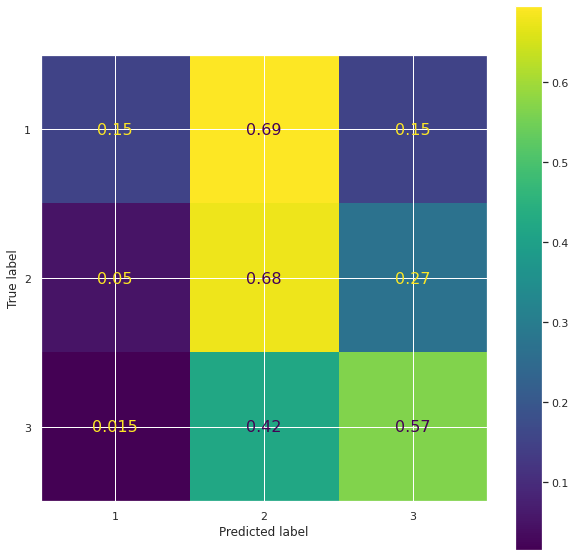

In [ ]:
# Run the model and show the model evaluation - Training

GB = GradientBoostingClassifier(random_state = 123)
GB.fit(x_train, y_train)
gbpred_train = GB.predict(x_train)
evalModel(x_train,y_train, GB)
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(GB, x_train, y_train, ax=ax,normalize='true')
print(classification_report(y_train, gbpred_train, target_names=['1','2','3']))

### XGBoost

Accuracy  : 0.52535
Recall    : 0.52535
Precision : 0.52535
F1 score  : 0.52535


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           1       0.54      0.12      0.19     33806
           2       0.49      0.69      0.57     70580
           3       0.58      0.56      0.57     59923

    accuracy                           0.53    164309
   macro avg       0.54      0.46      0.45    164309
weighted avg       0.53      0.53      0.49    164309



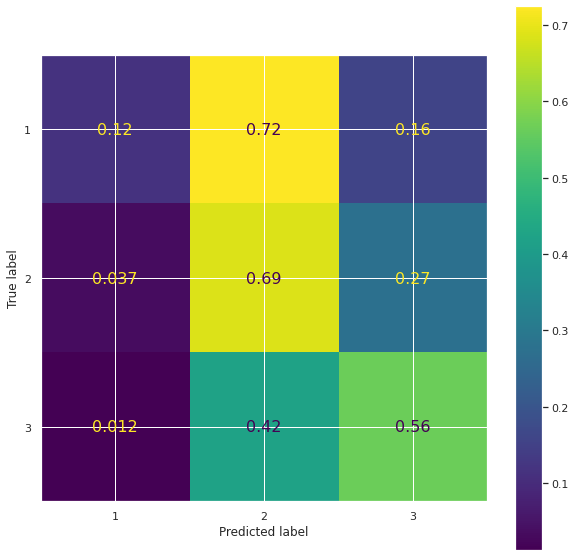

In [ ]:
# Run the model and show the model evaluation - Training

XGB= XGBClassifier(random_state = 123)
XGB.fit(x_train, y_train)
xgbpred_train = XGB.predict(x_train)
evalModel(x_train,y_train, XGB)
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(XGB, x_train, y_train, ax=ax,normalize='true')
print(classification_report(y_train, xgbpred_train, target_names=['1','2','3']))

### Regresi Logistic

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy  : 0.51801
Recall    : 0.51801
Precision : 0.51801
F1 score  : 0.51801


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           1       0.51      0.15      0.23     33806
           2       0.49      0.67      0.56     70580
           3       0.57      0.55      0.56     59923

    accuracy                           0.52    164309
   macro avg       0.52      0.46      0.45    164309
weighted avg       0.52      0.52      0.49    164309



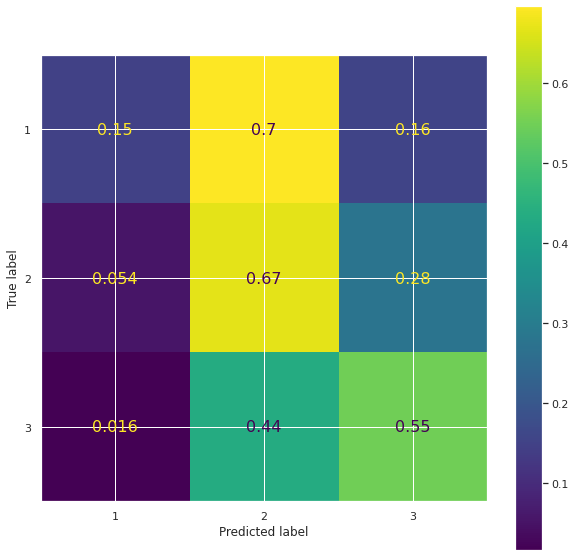

In [ ]:
## Regresi Logistic model evaluation - Training

rlcv = LogisticRegression(random_state = 123)
rlcv.fit(x_train,y_train)
rlcvpred = rlcv.predict(x_train)
evalModel(x_train, y_train, rlcv)
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(rlcv, x_train, y_train,ax=ax,normalize='true')
print(classification_report(y_train, rlcvpred, target_names=['1','2', '3']))



### Random Forest

Accuracy  : 0.99811
Recall    : 0.99811
Precision : 0.99811
F1 score  : 0.99811


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           1       1.00      1.00      1.00     33806
           2       1.00      1.00      1.00     70580
           3       1.00      1.00      1.00     59923

    accuracy                           1.00    164309
   macro avg       1.00      1.00      1.00    164309
weighted avg       1.00      1.00      1.00    164309



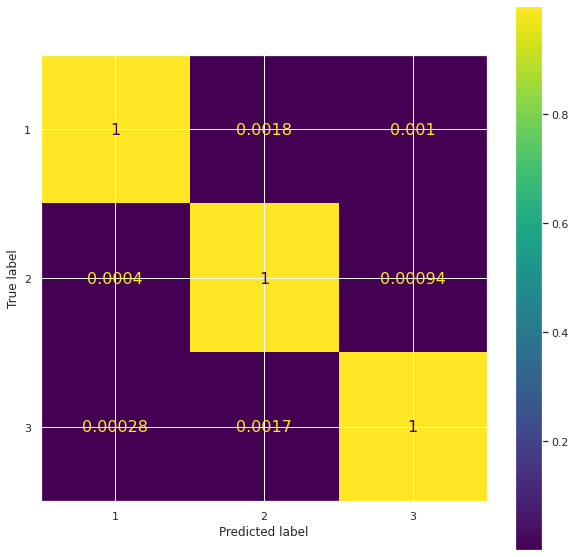

In [ ]:
# Run the model and show the model evaluation - Training

RFC = RandomForestClassifier(random_state = 123, n_estimators=20)
RFC.fit(x_train, y_train)
rfcpred_train = RFC.predict(x_train)
evalModel(x_train,y_train, RFC)
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(RFC, x_train, y_train, ax=ax,normalize='true')
print(classification_report(y_train, rfcpred_train, target_names=['1','2','3']))

In [ ]:
# Print y_test Predict

y_test = RFC.predict(x_test)
y_test

array([2, 2, 2, ..., 2, 3, 2])

In [ ]:
data_bersih_test['Interest_Rate'] = y_test
data_bersih_test.shape

(109541, 12)

In [ ]:
data_bersih_test.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Interest_Rate
0,10164310,27500,greatthan_10years,Mortgage,129000.00,VERIFIED_income,debt_consolidation,12.87,0.00,10.00,37.00,2
1,10164311,26000,greatthan_10years,Mortgage,110000.00,not_verified,credit_card,11.37,0.00,6.00,23.00,2
2,10164312,6075,lessthan_1year,Rent,75000.00,VERIFIED_income,debt_consolidation,6.83,2.00,5.00,20.00,2
3,10164313,12000,greatthan_10years,Mortgage,73000.00,VERIFIED_income_source,debt_consolidation,7.76,0.00,6.00,8.00,2
4,10164314,35000,lessthan_1year,Mortgage,131993.50,not_verified,debt_consolidation,9.62,0.00,9.00,21.00,2


In [ ]:
count_y_test = data_bersih_test['Interest_Rate'].value_counts()
count_y_test

2    55621
3    38627
1    15293
Name: Interest_Rate, dtype: int64

In [ ]:
percent_y_test = data_bersih_test['Interest_Rate'].value_counts() * 100/len(data_bersih_test['Interest_Rate'])
percent_y_test

2   50.78
3   35.26
1   13.96
Name: Interest_Rate, dtype: float64

In [ ]:
data_bersih_test.to_csv('data_bersih_test.csv')